# **Importing Modules**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, classification_report
import cv2
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns 

# **Importing Data**

In [2]:
no_mask_path = "/kaggle/input/face-mask-detection/annotations/"
mask_path = "/kaggle/input/face-mask-detection/images/"

images = [*os.listdir("/kaggle/input/face-mask-detection/images")]
output_data_path =  '.'

**Image Data to DataFrame Conversion**

In [3]:
img_masks = []
mask_label = []
for i in os.listdir(mask_path):
    img = os.path.join(mask_path + "/", i)
    img_masks.append(img)
    mask_label.append("mask")   
image_no_mask = []
target_no_mask = []
for i in os.listdir(no_mask_path):
    img = os.path.join(no_mask_path + "/", i)
    image_no_mask.append(img)
    target_no_mask.append("without_mask")
mask_df = pd.DataFrame()
mask_df["image"] = img_masks
mask_df["target"] = mask_label
no_mask_df = pd.DataFrame()
no_mask_df["image"] = image_no_mask
no_mask_df["target"] = target_no_mask
df = pd.concat([mask_df, no_mask_df], axis = 0, ignore_index = True)
df = shuffle(df)

**DataFrame Shape**

In [4]:
df.shape

(1706, 2)

**DataFrame Before Processing**

In [5]:
df.head()

,image,target
498,/kaggle/input/face-mask-detection/images//maks...,mask
688,/kaggle/input/face-mask-detection/images//maks...,mask
789,/kaggle/input/face-mask-detection/images//maks...,mask
434,/kaggle/input/face-mask-detection/images//maks...,mask
608,/kaggle/input/face-mask-detection/images//maks...,mask


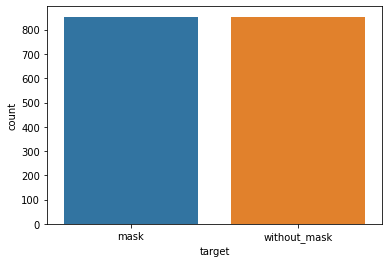

In [6]:
sns.countplot(df["target"]);

**Sample Image(Image from Dataset)**

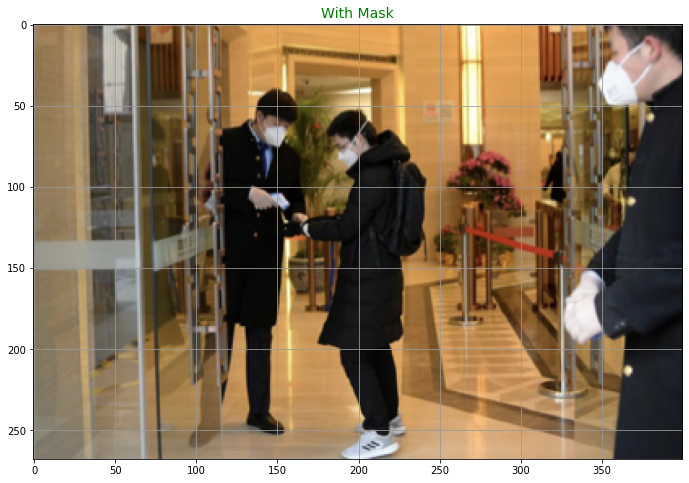

In [7]:
plt.figure(figsize=(12,8))
img = load_img(mask_df["image"][1])
plt.imshow(img)
plt.title("With Mask", color = "green", size = 14)
plt.grid(color='#999999', linestyle='-')
plt.show()

**Extracting Features from Single Image**

In [8]:
def parse_annotation(path):
    tree = ET.parse(path)
    root = tree.getroot()
    constants = {}
    objects = [child for child in root if child.tag == 'object']
    for element in tree.iter():
        if element.tag == 'filename':
            constants['file'] = element.text[0:-4]
        if element.tag == 'size':
            for dim in list(element):
                if dim.tag == 'width':
                    constants['width'] = int(dim.text)
                if dim.tag == 'height':
                    constants['height'] = int(dim.text)
                if dim.tag == 'depth':
                    constants['depth'] = int(dim.text)
    object_params = [parse_annotation_object(obj) for obj in objects]
    #print(constants)
    full_result = [merge(constants,ob) for ob in object_params]
    return full_result 

def parse_annotation_object(annotation_object):
    params = {}
    for param in list(annotation_object):
        if param.tag == 'name':
            params['name'] = param.text
        if param.tag == 'bndbox':
            for coord in list(param):
                if coord.tag == 'xmin':
                    params['xmin'] = int(coord.text)              
                if coord.tag == 'ymin':
                    params['ymin'] = int(coord.text)
                if coord.tag == 'xmax':
                    params['xmax'] = int(coord.text)
                if coord.tag == 'ymax':
                    params['ymax'] = int(coord.text)
            
    return params       
 
def merge(dict1, dict2):
    res = {**dict1, **dict2}
    return res

In [9]:

dataset = [parse_annotation(anno) for anno in glob.glob(no_mask_path+"/*.xml") ]

full_dataset = sum(dataset, [])

df = pd.DataFrame(full_dataset)

**DataFrame After Extraction of Feature**

In [10]:
df.head(5)

,file,width,height,depth,name,xmin,ymin,xmax,ymax
0,maksssksksss737,400,226,3,with_mask,28,55,46,71
1,maksssksksss737,400,226,3,with_mask,98,62,111,78
2,maksssksksss737,400,226,3,mask_weared_incorrect,159,50,193,90
3,maksssksksss737,400,226,3,with_mask,293,59,313,80
4,maksssksksss737,400,226,3,with_mask,352,51,372,72


**Detach one image from the dataset so that it can be used to illustrate the findings at the project's result.**

In [11]:
final_test_image = 'maksssksksss0'
df_final_test = df.loc[df["file"] == final_test_image]
images.remove(f'{final_test_image}.png')
df = df.loc[df["file"] != final_test_image]

In [12]:
df["name"].value_counts()

with_mask                3231
without_mask              715
mask_weared_incorrect     123
Name: name, dtype: int64

Text(0, 0.5, 'Name')

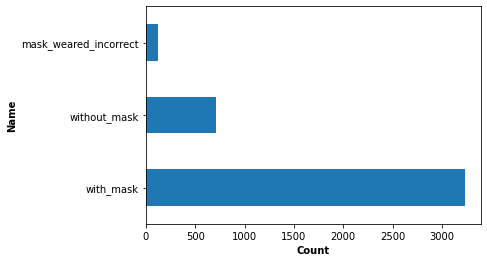

In [13]:
df["name"].value_counts().plot(kind='barh')
plt.xlabel('Count', fontsize = 10, fontweight = 'bold')
plt.ylabel('Name', fontsize = 10, fontweight = 'bold')

In [14]:
labels = df['name'].unique()
directory = ['train', 'test', 'val']
output_data_path =  '.'

import os
for label in labels:
    for d in directory:
        path = os.path.join(output_data_path, d, label)
        if not os.path.exists(path):
            os.makedirs(path)

**Coordinates**

In [15]:
def crop_img(image_path, x_min, y_min, x_max, y_max):
    x_shift = (x_max - x_min) * 0.1
    y_shift = (y_max - y_min) * 0.1
    img = Image.open(image_path)
    cropped = img.crop((x_min - x_shift, y_min - y_shift, x_max + x_shift, y_max + y_shift))
    return cropped

**Faces Extraction from Image**

In [16]:
def extract_faces(image_name, image_info):
    faces = []
    df_one_img = image_info[image_info['file'] == image_name[:-4]][['xmin', 'ymin', 'xmax', 'ymax', 'name']]
    for row_num in range(len(df_one_img)):
        x_min, y_min, x_max, y_max, label = df_one_img.iloc[row_num] 
        image_path = os.path.join(mask_path, image_name)
        faces.append((crop_img(image_path, x_min, y_min, x_max, y_max), label,f'{image_name[:-4]}_{(x_min, y_min)}'))
    return faces

In [17]:
cropped_faces = [extract_faces(img, df) for img in images]

In [18]:
flat_cropped_faces = sum(cropped_faces, [])

**Dividing Faces into Categories**

In [19]:
with_mask = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "with_mask"]
mask_weared_incorrect = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "mask_weared_incorrect"]
without_mask = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "without_mask"]

In [20]:
print(len(with_mask))
print(len(without_mask))
print(len(mask_weared_incorrect))
print(len(with_mask) + len(without_mask) + len(mask_weared_incorrect))

3231
715
123
4069


**Train Test and Validation for Different Categories**

In [21]:
train_with_mask, test_with_mask = train_test_split(with_mask, test_size=0.20, random_state=42)
test_with_mask, val_with_mask = train_test_split(test_with_mask, test_size=0.7, random_state=42)

train_mask_weared_incorrect, test_mask_weared_incorrect = train_test_split(mask_weared_incorrect, test_size=0.20, random_state=42)
test_mask_weared_incorrect, val_mask_weared_incorrect = train_test_split(test_mask_weared_incorrect, test_size=0.7, random_state=42)

train_without_mask, test_without_mask = train_test_split(without_mask, test_size=0.20, random_state=42)
test_without_mask, val_without_mask = train_test_split(test_without_mask, test_size=0.7, random_state=42)

In [22]:
print("Size of Train Set with Mask :",len(train_with_mask))
print("Size of Test Set with Mask :",len(test_with_mask))
print("Size of Validation Set with Mask :",len(val_with_mask))

Size of Train Set with Mask : 2584
Size of Test Set with Mask : 194
Size of Validation Set with Mask : 453


In [23]:
print("Size of Train Set with No_Mask :",len(train_without_mask))
print("Size of Test Set with No_Mask :",len(test_without_mask))
print("Size of Validation Set with No_Mask :",len(val_without_mask))

Size of Train Set with No_Mask : 572
Size of Test Set with No_Mask : 42
Size of Validation Set with No_Mask : 101


In [24]:
print("Size of Train Set with Incorrectly_Weared_Mask :",len(train_mask_weared_incorrect))
print("Size of Test Set with Incorrectly_Weared_Mask :",len(test_mask_weared_incorrect))
print("Size of Validation Set with Incorrectly_Weared_Mask :",len(val_mask_weared_incorrect))

Size of Train Set with Incorrectly_Weared_Mask : 98
Size of Test Set with Incorrectly_Weared_Mask : 7
Size of Validation Set with Incorrectly_Weared_Mask : 18


In [25]:
def save_image(image, image_name, output_data_path,  dataset_type, label):
    output_path = os.path.join(output_data_path, dataset_type, label ,f'{image_name}.png')
    image.save(output_path)  

In [26]:
for image, image_name in train_with_mask:
    save_image(image, image_name, output_data_path, 'train', 'with_mask')

for image, image_name in train_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'train', 'mask_weared_incorrect')

for image, image_name in train_without_mask:
    save_image(image, image_name, output_data_path, 'train', 'without_mask')

for image, image_name in test_with_mask:
    save_image(image, image_name, output_data_path, 'test', 'with_mask')

for image, image_name in test_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'test', 'mask_weared_incorrect')

for image, image_name in test_without_mask:
    save_image(image, image_name, output_data_path, 'test', 'without_mask')
        
for image, image_name in val_with_mask:
    save_image(image, image_name, output_data_path, 'val', 'with_mask')

for image, image_name in val_without_mask:
    save_image(image, image_name, output_data_path, 'val', 'without_mask')

for image, image_name in val_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'val', 'mask_weared_incorrect')

# **Convolutional Neural Model**

**Model**

In [27]:
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 3,  padding='same', activation = 'relu', input_shape = (35,35,3)))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 32, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 64, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(units = 500, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 3, activation = 'softmax'))

model.summary()

2022-12-15 20:06:03.675214: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 20:06:03.676122: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 20:06:03.969897: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 20:06:03.970743: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 20:06:03.971496: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 35, 35, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 17, 17, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 17, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 64)          0

**Train Validation and Test**

In [28]:
batch_size = 8
epochs = 50

datagen = ImageDataGenerator(
    rescale=1.0 / 255, horizontal_flip=True, zoom_range=0.1, shear_range=0.2, width_shift_range=0.1,
    height_shift_range=0.1, rotation_range=4, vertical_flip=False

)

val_datagen = ImageDataGenerator(
    rescale=1.0 / 255
)
 

train_generator = datagen.flow_from_directory(
    directory='/kaggle/working/train', 
    target_size = (35,35),
    class_mode="categorical", batch_size=batch_size, shuffle=True

)

# Validation data
val_generator = val_datagen.flow_from_directory(
    directory='/kaggle/working/val', 
    target_size = (35,35),
    class_mode="categorical", batch_size=batch_size, shuffle=True
)

# Test data
test_generator = val_datagen.flow_from_directory(
    directory='/kaggle/working/test', 
    target_size = (35,35),
    class_mode="categorical", batch_size=batch_size, shuffle=False
)

Found 3254 images belonging to 3 classes.
Found 572 images belonging to 3 classes.
Found 243 images belonging to 3 classes.


In [29]:
data_size = len(train_generator)

steps_per_epoch = int(data_size / batch_size)
print(f"steps_per_epoch: {steps_per_epoch}")

val_steps = int(len(val_generator) // batch_size)
print(f"val_steps: {val_steps}")

steps_per_epoch: 50
val_steps: 9


**Configure Model for Training**

In [30]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']
)

**Early Stoppping**

In [31]:
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

**Learning Rate Monitor**

In [32]:
lrr = ReduceLROnPlateau(monitor='val_loss',patience=8,verbose=1,factor=0.5, min_lr=0.00001)

In [33]:
model_history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    shuffle=True,
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=[early_stopping, lrr]
)

2022-12-15 20:06:09.599446: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-12-15 20:06:12.484297: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


50/50 [==============================] - 14s 24ms/step - loss: 0.6240 - accuracy: 0.8050 - recall: 0.7725 - precision: 0.8047 - auc: 0.8958 - val_loss: 0.4311 - val_accuracy: 0.8333 - val_recall: 0.8333 - val_precision: 0.8333 - val_auc: 0.9557
Epoch 2/50
50/50 [==============================] - 1s 15ms/step - loss: 0.5621 - accuracy: 0.7850 - recall: 0.7775 - precision: 0.8099 - auc: 0.9173 - val_loss: 0.3506 - val_accuracy: 0.8333 - val_recall: 0.8333 - val_precision: 0.8451 - val_auc: 0.9658
Epoch 3/50
50/50 [==============================] - 1s 16ms/step - loss: 0.3322 - accuracy: 0.8900 - recall: 0.8675 - precision: 0.9084 - auc: 0.9687 - val_loss: 0.4593 - val_accuracy: 0.8333 - val_recall: 0.8056 - val_precision: 0.8286 - val_auc: 0.9554
Epoch 4/50
50/50 [==============================] - 1s 17ms/step - loss: 0.2997 - accuracy: 0.8925 - recall: 0.8825 - precision: 0.9098 - auc: 0.9738 - val_loss: 0.4225 - val_accuracy: 0.8056 - val_recall: 0.7778 - val_precision: 0.8235 - val_au

**Accuracy and Other Comparision Parameters**

In [34]:
model_loss, model_acc, recall, precision, auc = model.evaluate(test_generator)

31/31 [==============================] - 0s 9ms/step - loss: 0.1906 - accuracy: 0.9383 - recall: 0.9342 - precision: 0.9380 - auc: 0.9905


**Accuracy**

In [35]:
print('Accuaracy is' ,{model_acc*100})

Accuaracy is {93.82715821266174}


**Prediction on Test Data**

In [36]:
predictions = model.predict(test_generator)

In [37]:
def plot_loss_and_accuracy(history):
    history_df = pd.DataFrame(history)
    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    
    history_df.loc[0:, ['loss', 'val_loss']].plot(ax=ax[0])
    ax[0].set(xlabel = 'epoch number', ylabel = 'loss')

    history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=ax[1])
    ax[1].set(xlabel = 'epoch number', ylabel = 'accuracy')

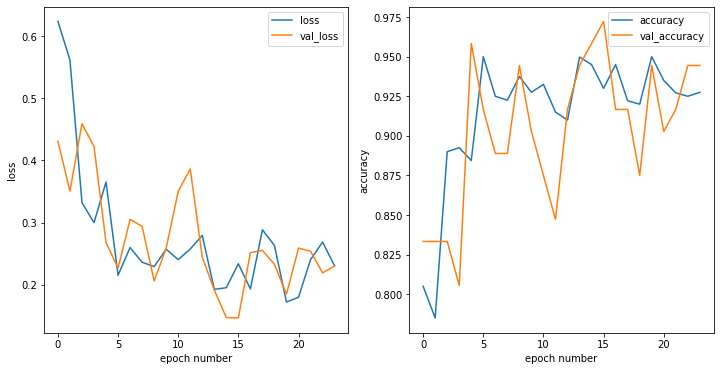

In [38]:
plot_loss_and_accuracy(model_history.history)

Class Predicted: with_mask , True label: with_mask


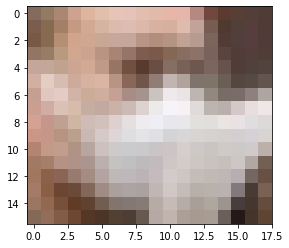

In [39]:
 

paths = test_generator.filenames 

 

y_pred = model.predict(test_generator).argmax(axis=1) # Predict prob and get Class Indices
classes = test_generator.class_indices  # Map of Indices to Class name

 

a_img_rand = np.random.randint(0,len(paths))   # A rand to pick a rand image
img = cv2.imread(os.path.join(output_data_path,'test', paths[a_img_rand]))      
colored_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # colored output image

 

#img = image.img_to_array(img)
plt.imshow(colored_img)
true_label = paths[a_img_rand].split('/')[0]
predicted_label = list(classes)[y_pred[a_img_rand]]
print(f'Class Predicted: {predicted_label} , True label: {true_label}')


**Confusion Matrix**

In [40]:
def evaluation(y, y_hat, title = 'Confusion Matrix'):
    cm = confusion_matrix(y, y_hat)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws={'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    
    plt.show()

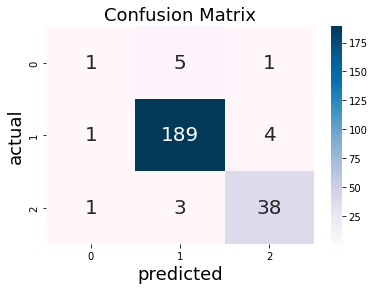

In [41]:
y_true = test_generator.labels
y_pred = model.predict(test_generator).argmax(axis=1) # Predict prob and get Class Indices

evaluation(y_true, y_pred)

**Overall Predition Categories**

In [42]:
display(classes)
np.bincount(y_pred)

{'mask_weared_incorrect': 0, 'with_mask': 1, 'without_mask': 2}

array([  3, 197,  43])

**Testing**

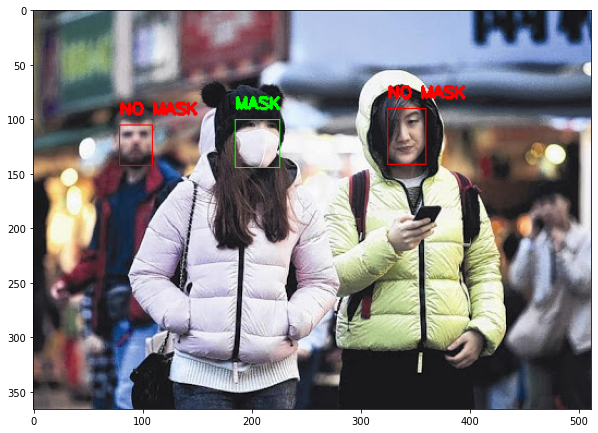

In [43]:
import cv2
img = cv2.imread(os.path.join(mask_path, f'{final_test_image}.png'))      
colored_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # colored output image

#print(type(colored_img))
mask_label = {0:'MASK INCORRECT',1:'MASK', 2:'NO MASK'}
color_label = {0:(0,255,255),1:(0, 255,0), 2:(255,0,0)}
cropped_faces = extract_faces(f'{final_test_image}.png', df_final_test)

df_test_img = df_final_test[['xmin', 'ymin', 'xmax', 'ymax', 'name']]
#df_test_img
#for row_num in range(len(df_test_img)):
for idx, face in enumerate(cropped_faces):    
    #print(idx)
    x_min, y_min, x_max, y_max, label = df_test_img.iloc[idx] 
    #print(x_min, y_min, x_max, y_max, label)
    #print(face[0])
    resized_face = cv2.resize(np.array(face[0]),(35,35))
    reshaped_face = np.reshape(resized_face,[1,35,35,3])/255.0

    face_result = model.predict(reshaped_face)
    cv2.putText(colored_img,mask_label[face_result.argmax()],(x_min, y_min-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,color_label[face_result.argmax()],2)
    cv2.rectangle(colored_img,(x_min, y_min), (x_max, y_max), color_label[face_result.argmax()])

plt.figure(figsize=(10, 10))    
plt.imshow(colored_img)